# Analysis of wage and hour case data from US state labor agencies

## Data import and preparation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from src.shared_functions import get_coverage_df

tqdm.pandas()
pd.set_option("display.float_format", lambda x: "%.3f" % x)


In [2]:
df = (
    pd.read_csv(
        "input/state_complaints.csv.gz",
        low_memory=False,
        parse_dates=["date_opened", "date_closed", "date_paid"],
    )
    # keep only 1 row per case. some rows contain multiple violation
    # categories, but this notebook will not address those.
    .drop_duplicates(subset="case_uuid", keep="first")
)


### Data completeness


The data states provided in response to my public records requests was wildly inconsistent. I requested a long list of fields -- case statuses, start, end and paid dates, amounts claimed, assessed by the agency and paid -- but not all states possessed that data. Many states exported data directly from their case management systems, so lots of those fields were missing. This section will examine the completeness of various data points and explain how I am handling missing data. 

NOTE: the `get_coverage_df` function outputs the completeness (% non-null) of key columns in the analysis. You can find it at `shared/src/shared_functions.py`.

The data overall is very incomplete and has a ton of missing values. This is largely because many of the cases sent from case management systems are not completed. 

In [3]:
get_coverage_df(df, by_state=False)


case_status       0.346
amount_claimed    0.483
amount_assessed   0.443
amount_paid       0.371
date_opened       0.983
date_closed       0.265
dtype: float64

This state breakdown heatmap shows which states have which data. 

<AxesSubplot: ylabel='state_name'>

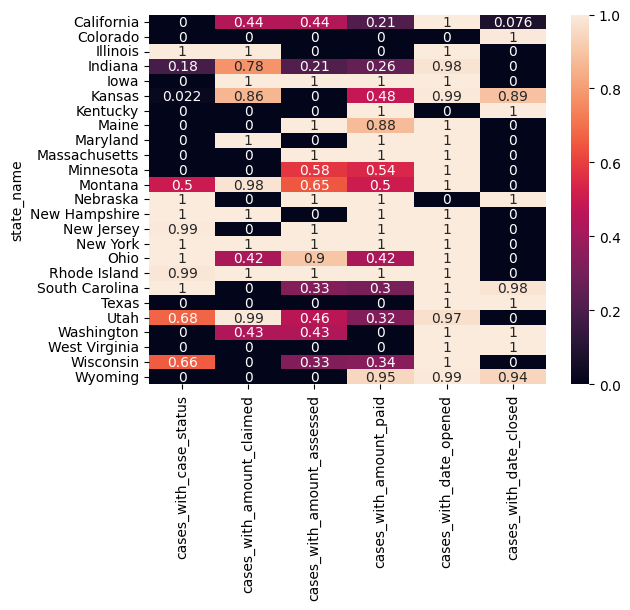

In [4]:
sns.heatmap(get_coverage_df(df).iloc[:, 1:], annot=True)


The `determine_case_outcome` task of this repo assigns a `case_decided_in_favor_of_claimant` column to the dataframe, as well as the reason why that task determined the case outcome. 

In [5]:
df[["case_decided_in_favor_of_claimant", "case_decided_in_favor_of_claimant_reason"]].value_counts().to_frame("rows")


rows
case_decided_in_favor_of_claimant case_decided_in_favor_of_claimant_reason                  
True                              has amount paid                                     198939
False                             has no assessed amount, but state provided asse...  181894
True                              state only provided closed cases                     60683
                                  has assessed amount greater than 0                   41040
False                             has assessed amount less than or equal to 0          37868
                                  has open or incomplete case status                   28684
True                              has final case status                                 2947

When you select only cases marked completed, you get much better completeness.

In [6]:
get_coverage_df(df.query("case_decided_in_favor_of_claimant == True"), by_state=False)


case_status       0.368
amount_claimed    0.596
amount_assessed   0.664
amount_paid       0.656
date_opened       0.972
date_closed       0.326
dtype: float64

<AxesSubplot: ylabel='state_name'>

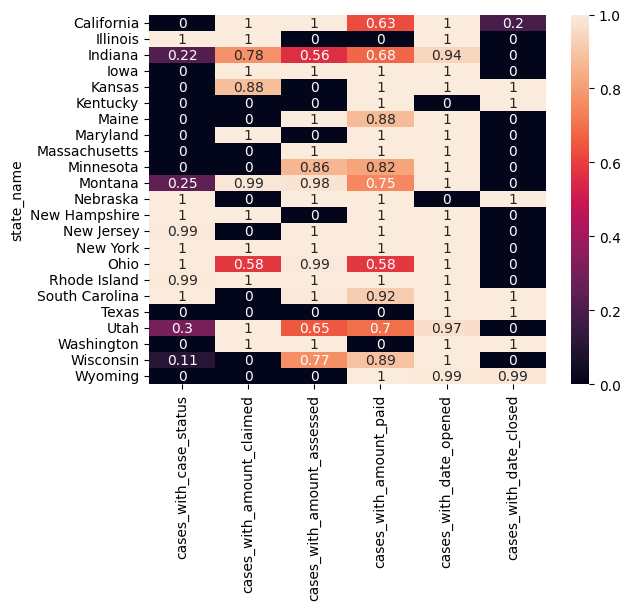

In [7]:
sns.heatmap(get_coverage_df(df.query("case_decided_in_favor_of_claimant == True")).iloc[:, 1:], annot=True)


Those amount fields still contain missing data, but most cases contain at least one non-null amount. 

In [8]:
no_amounts = df.query("case_decided_in_favor_of_claimant == True").query(
    "amount_claimed.isnull() &  amount_assessed.isnull() & amount_paid.isnull()"
)
atleast_one_amount = df.query("case_decided_in_favor_of_claimant == True").query(
    "amount_claimed.notnull() | amount_assessed.notnull() | amount_paid.notnull()"
)
print(
    f"{no_amounts.shape[0]} rows "
    f"(%{no_amounts.shape[0]/len(df.query('case_decided_in_favor_of_claimant == True')) * 100:,}) "
    "have no amounts"
)


61079 rows (%20.11765132127177) have no amounts


There are also indeterminate cases, in which I couldn't determine whether the case was completed 

In [9]:
df.query("case_decided_in_favor_of_claimant.isnull()").shape


(15373, 16)

They contain very incomplete data, but all for one single reason: they are closed cases with no assessed amount and no paid amount in a state that didn't provide either. 

If the state provided either an assessed or paid amount, I can use those to determine the case outcome. But if the state provided only claim amounts or no amounts at all AND no clear case disposition other than "closed," I can't be confident that those cases are all decided in favor of the claimants. 

In [10]:
print(
    df.query(
        "case_decided_in_favor_of_claimant.isnull()"
    ).case_decided_in_favor_of_claimant_reason.value_counts()
)
get_coverage_df(df.query("case_decided_in_favor_of_claimant.isnull()"), by_state=False)


closed case with no assessed amount and no paid amount in a state that provided neither    15373
Name: case_decided_in_favor_of_claimant_reason, dtype: int64


case_status       0.724
amount_claimed    0.725
amount_assessed   0.000
amount_paid       0.000
date_opened       0.970
date_closed       0.275
dtype: float64

In [11]:
df.query("case_decided_in_favor_of_claimant.isnull()").state_name.value_counts()


Illinois         11141
West Virginia     3778
Colorado           454
Name: state_name, dtype: int64

I'll run different versions of the analysis to see how much the results change

## Analysis

I will focus on the following data points: 
1. overall amount assessed and the impacts that can have
2. amount claimed or assessed by the state vs. the amount paid by the company
3. the amount of time these cases take to resolve


### Case duration

In [12]:
duration_df = (
    df.query("case_decided_in_favor_of_claimant == True")
    .copy()
    .assign(case_duration=lambda x: x.date_closed - x.date_opened)
    .assign(duration_days=lambda x: x.case_duration.dt.days)
)

duration_df.case_duration.describe()


count                          91217
mean     310 days 14:02:53.448449200
std      412 days 07:59:42.409025324
min                  0 days 00:00:00
25%                105 days 00:00:00
50%                195 days 00:00:00
75%                337 days 00:00:00
max               4585 days 00:00:00
Name: case_duration, dtype: object

In [13]:
(
    duration_df.groupby(
        pd.cut(duration_df.duration_days, [0, 30, 60, 90, 180, 360, 720, 999999])
    )
    .size()
    .to_frame("total_cases")
    .rename(
        index={
            pd.Interval(0, 30, closed="right"): "0-30 days",
            pd.Interval(30, 60, closed="right"): "30-60 days",
            pd.Interval(60, 90, closed="right"): "60-90 days",
            pd.Interval(90, 180, closed="right"): "90-180 days",
            pd.Interval(180, 360, closed="right"): "180-360 days",
            pd.Interval(360, 720, closed="right"): "360-720 days",
            pd.Interval(720, 999999, closed="right"): "720+ days",
        }
    )
)


,total_cases
duration_days,
0-30 days,4594
30-60 days,5102
60-90 days,8393
90-180 days,24256
180-360 days,28515
360-720 days,12934
720+ days,7323


In [14]:
duration_df.groupby("state_name").duration_days.describe().dropna()


,count,mean,std,min,25%,50%,75%,max
state_name,,,,,,,,
California,12366.000,523.836,306.061,26.000,300.000,439.000,676.750,1951.000
Kansas,4917.000,158.355,306.790,0.000,47.000,99.000,168.000,3869.000
South Carolina,4807.000,65.342,48.877,0.000,35.000,57.000,84.000,826.000
Texas,60683.000,332.816,450.520,29.000,133.000,208.000,323.000,4585.000
Washington,6364.000,55.863,55.484,0.000,22.000,43.000,69.000,1197.000
Wyoming,2080.000,99.992,137.802,0.000,24.000,48.000,124.000,1114.000
